In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

# model
from sklearn.ensemble import RandomForestRegressor

SEED=42

In [3]:
path = 'drive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'train'),'\n', 
      os.listdir(path + 'test'),'\n', 
#       os.listdir(path + '../metrics'),'\n', 
      os.listdir(path + '../scripts'))

['train_payment.csv', 'train_trade.csv', 'train_pledge.csv', 'train_combat.csv', 'train_label.csv', 'train_activity.csv', 'train_merge_bjw.csv'] 
 ['test1_activity.csv', 'test1_combat.csv', 'test2_activity.csv', 'test1_pledge.csv', 'test2_combat.csv', 'test2_trade.csv', 'test1_trade.csv', 'test1_payment.csv', 'test2_payment.csv', 'test2_pledge.csv'] 
 ['explortary data', 'model', 'data merge', 'test1_predict.csv', 'test2_predict.csv', "hh's work", 'metrics']


In [0]:
train_label = pd.read_csv(path + 'train/train_label.csv')
train_activity = pd.read_csv(path + 'train/train_activity.csv')
#train_combat = pd.read_csv(path + 'train/train_combat.csv')
train_payment = pd.read_csv(path + 'train/train_payment.csv')
#train_pledge = pd.read_csv(path + 'train/train_pledge.csv')
#train_trade = pd.read_csv(path + 'train/train_trade.csv')

test1_activity = pd.read_csv(path + 'test/test1_activity.csv')
#test1_combat = pd.read_csv(path + 'test/test1_combat.csv')
test1_payment = pd.read_csv(path + 'test/test1_payment.csv')
#test1_pledge = pd.read_csv(path + 'test/test1_pledge.csv')
#test1_trade = pd.read_csv(path + 'test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'test/test2_activity.csv')
#test2_combat = pd.read_csv(path + 'test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'test/test2_payment.csv')
#test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv')
#test2_trade = pd.read_csv(path + 'test/test2_trade.csv')

In [5]:
train_df = train_activity.groupby(['acc_id', 'day']).sum().reset_index()
test1_df = test1_activity.groupby(['acc_id', 'day']).sum().reset_index()
test2_df = test2_activity.groupby(['acc_id', 'day']).sum().reset_index()
train_df.head()

,acc_id,day,char_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,233598,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,233598,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,2,3,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,2,4,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,2,5,233598,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [0]:
def mul_logday(df):
  acc_id = df['acc_id']
  playtime = df['playtime'] * np.log1p(df['day'])
  npc_kill = df['npc_kill'] * np.log1p(df['day'])
  solo_exp = df['solo_exp'] * np.log1p(df['day'])	
  party_exp = df['party_exp'] * np.log1p(df['day'])
  quest_exp = df['quest_exp'] * np.log1p(df['day'])	
  rich_monster = df['rich_monster'] * np.log1p(df['day'])
  death = df['death'] * np.log1p(df['day'])
  revive = df['revive'] * np.log1p(df['day'])
  exp_recovery = df['exp_recovery'] * np.log1p(df['day'])
  fishing = df['fishing'] * np.log1p(df['day'])
  private_shop = df['private_shop'] * np.log1p(df['day'])
  game_money_change = df['game_money_change'] * np.log1p(df['day'])
  enchant_count = df['enchant_count'] * np.log1p(df['day'])

  
  
  df2 = pd.concat([acc_id,
                   playtime,
                   npc_kill,
                   solo_exp,
                   party_exp,
                   quest_exp,
                   rich_monster,
                   death,
                   revive,
                   exp_recovery,
                   fishing,
                   private_shop,
                   game_money_change,
                   enchant_count
        ], axis=1)
  df2.columns = ['acc_id',	'playtime',	'npc_kill',	'solo_exp',	'party_exp',	'quest_exp',	'rich_monster',	'death',	'revive',	'exp_recovery',	'fishing',	'private_shop',	'game_money_change',	'enchant_count']
  
  return df2 

In [0]:
train_log = mul_logday(train_df).groupby('acc_id').sum().reset_index()
test1_log = mul_logday(test1_df).groupby('acc_id').sum().reset_index()
test2_log = mul_logday(test2_df).groupby('acc_id').sum().reset_index()

In [8]:
print(train_log.shape)
train_log.head()

(40000, 14)


,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,233.783076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,216.802190,-0.576780,0.0
1,5,19.344491,10.250427,6.635372,2.242384,0.354213,27.473720,0.810392,0.815182,0.0,11.562847,0.000000,0.478148,0.0
2,8,47.868651,54.525445,47.135491,0.000000,3.256438,4.882802,181.463134,182.535773,0.0,12.253073,0.000000,-0.850695,0.0
3,17,74.665726,55.836831,19.992348,23.239199,5.547090,54.490246,4.349040,4.374747,0.0,40.100724,0.000000,-0.315484,0.0
4,20,68.048329,63.714712,0.532379,0.209841,0.210329,23.070537,2.844294,2.861107,0.0,12.368385,7.437788,-1.158669,0.0


In [9]:
print(test1_log.shape)
test1_log.head()

(20000, 14)


,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,3.885079,2.260118,27.132465,0.000000,105.989853,0.000000,2.269347,1.458584,0.0,0.000000,0.000000,0.003153,0.0
1,15,217.999673,46.903634,1.624636,0.000000,0.000000,0.000000,19.857092,14.307412,0.0,0.000000,0.000000,-0.001638,0.0
2,16,0.265246,0.000000,0.000000,0.000000,0.311719,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.111533,0.0
3,18,125.629544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,115.890995,0.432794,0.0
4,19,215.489360,189.480471,0.573756,2.234723,0.017602,3.988984,2.302180,1.630025,0.0,100.668835,0.000000,0.678166,0.0


In [10]:
print(test2_log.shape)
test2_log.head()

(20000, 14)


,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,224.214856,147.169244,1.294459,0.000000,0.000000,0.000000,7.150022,0.000000,0.0,0.000000,0.0,0.000075,0.0
1,3,6.861098,0.233196,0.024471,0.000000,0.192297,5.123964,0.000000,0.000000,0.0,2.288610,0.0,0.052859,0.0
2,9,0.264165,0.053483,0.019823,0.000000,0.224536,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.095663,0.0
3,14,20.579825,0.668760,0.106580,0.002559,0.019264,12.619506,3.149147,3.167762,0.0,1.694962,0.0,0.020587,0.0
4,26,79.486900,7.874910,0.590051,0.008965,0.000953,11.010068,82.243924,82.730072,0.0,229.735481,0.0,-1.294245,0.0


In [0]:
train_label_arr = train_label.sort_values('acc_id')

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb

In [0]:
FOLDS=5;SEED=42
def lgb_model(train, test, label, folds=FOLDS, seed=SEED):
    
    params = {
        'objective':'regression',
        "boosting": "gbdt",
        "num_iterations ":100,
        'num_leaves': 10000,
        'max_depth': 5,
        'learning_rate': 0.1,
        'min_data_in_leaf': 32, 
        'min_child_samples': 30,
        'min_child_weight': 0.5,
        'min_split_gain': 0.005,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9 ,
        "bagging_freq": 2,
        "bagging_seed": 42,
        "metric": 'mae',
        "lambda_l1": 0.1,
        "lambda_l2": 0.1
    }
    
    skf = StratifiedKFold(n_splits=folds, random_state=seed)
    kf = KFold(n_splits=folds, random_state=seed)
    
    oof_time = np.zeros(len(train))
    oof_spent = np.zeros(len(train))
    pred_time = np.zeros(len(test))
    pred_spent = np.zeros(len(test))
    
    for trn_idx, val_idx in skf.split(train, label['survival_time']):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'survival_time'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'survival_time'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_time[val_idx] = lgb_model.predict(train.loc[val_idx])/skf.n_splits
        pred_time += lgb_model.predict(test)/skf.n_splits
    
      
    for trn_idx, val_idx in kf.split(train):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'amount_spent'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'amount_spent'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_spent[val_idx] = lgb_model.predict(train.loc[val_idx])/kf.n_splits
        pred_spent += lgb_model.predict(test)/kf.n_splits
        
    
    return oof_time, oof_spent, pred_time, pred_spent

In [34]:
oof1_time, oof1_spent, pred1_time, pred1_spent = lgb_model(
    train_log, test1_log, train_label_arr, FOLDS, SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[232]	training's l1: 19.2932	valid_1's l1: 18.5281
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[230]	training's l1: 19.2753	valid_1's l1: 19.2593
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[6]	training's l1: 20.9521	valid_1's l1: 20.9616
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's l1: 20.7694	valid_1's l1: 22.0431
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 20.644	valid_1's l1: 22.2509
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 0.153963	valid_1's l1: 0.160604
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's 

In [0]:
oof1_df = pd.DataFrame([np.unique(train_activity['acc_id']), oof1_time.astype(int), oof1_spent]).T
oof1_df.columns = train_label.columns
oof1_df[['acc_id', 'survival_time']] = oof1_df[['acc_id', 'survival_time']].astype(int)

In [16]:
!ls

drive  sample_data  test1_predict.csv  test2_predict.csv


In [0]:
path = './drive/My Drive/bigcontest2019/scripts/model/'
os.chdir(path)
from metrics import score_function

In [0]:
from metrics import score_function

In [37]:
oof1_df2 = oof1_df.copy()
oof1_df2['amount_spent'] = oof1_df2['amount_spent']
oof1_df2.loc[(oof1_df2['amount_spent']<1) | (oof1_df2['amount_spent'].isnull()), 'amount_spent'] = 1
score_function.score_function(oof1_df2, train_label, path=False)

19288.11711347103


19288.11711347103

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


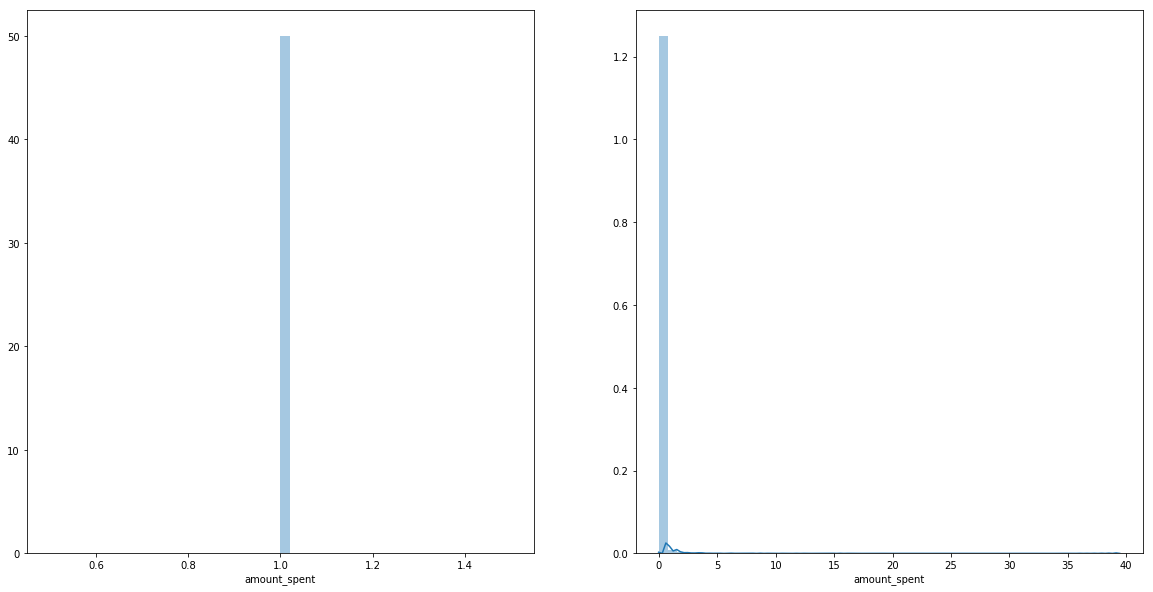

In [38]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.distplot(oof1_df2['amount_spent'])

plt.subplot(1, 2, 2)
sns.distplot(train_label['amount_spent'])

plt.show()

In [39]:
oof1_df2['survival_time'].min(), oof1_df2['survival_time'].mean(), oof1_df2['survival_time'].max(), oof1_df2['amount_spent'].min(), oof1_df2['amount_spent'].mean(), oof1_df2['amount_spent'].max()

(6, 9.208025, 14, 1.0, 1.0, 1.0)

In [0]:
pred1_df = pd.DataFrame([np.unique(test1_log['acc_id']), pred1_time.astype(int), pred1_spent]).T
pred1_df.columns = train_label.columns
pred1_df[['acc_id', 'survival_time']] = pred1_df[['acc_id', 'survival_time']].astype(int)

pred1_df.loc[pred1_df['survival_time']<1, 'survival_time'] = 1
pred1_df.loc[pred1_df['survival_time']>64, 'survival_time'] = 64

#pred1_df['amount_spent'] = pred1_df['amount_spent']/50

pred1_df.loc[(pred1_df['amount_spent']<1) | (pred1_df['amount_spent'].isnull()), 'amount_spent'] = 1

pred1_df.to_csv('./HH/0830/test1_predict.csv', index=False, encoding='utf-8')

In [41]:
oof2_time, oof2_spent, pred2_time, pred2_spent = lgb_model(
    train_log, test2_log, train_label_arr, FOLDS, SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[232]	training's l1: 19.2932	valid_1's l1: 18.5281
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[230]	training's l1: 19.2753	valid_1's l1: 19.2593
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[6]	training's l1: 20.9521	valid_1's l1: 20.9616
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2]	training's l1: 20.7694	valid_1's l1: 22.0431
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 20.644	valid_1's l1: 22.2509
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's l1: 0.153963	valid_1's l1: 0.160604
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1]	training's 

In [0]:
oof2_df = pd.DataFrame([np.unique(train_activity['acc_id']), oof2_time.astype(int), oof2_spent]).T
oof2_df.columns = train_label.columns
oof2_df[['acc_id', 'survival_time']] = oof2_df[['acc_id', 'survival_time']].astype(int)

In [43]:
oof2_df2 = oof2_df.copy()
oof2_df2['amount_spent'] = oof2_df2['amount_spent']
oof2_df2.loc[(oof2_df2['amount_spent']<1) | (oof2_df2['amount_spent'].isnull()), 'amount_spent'] = 1
score_function.score_function(oof2_df2, train_label, path=False)

19288.11711347103


19288.11711347103

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


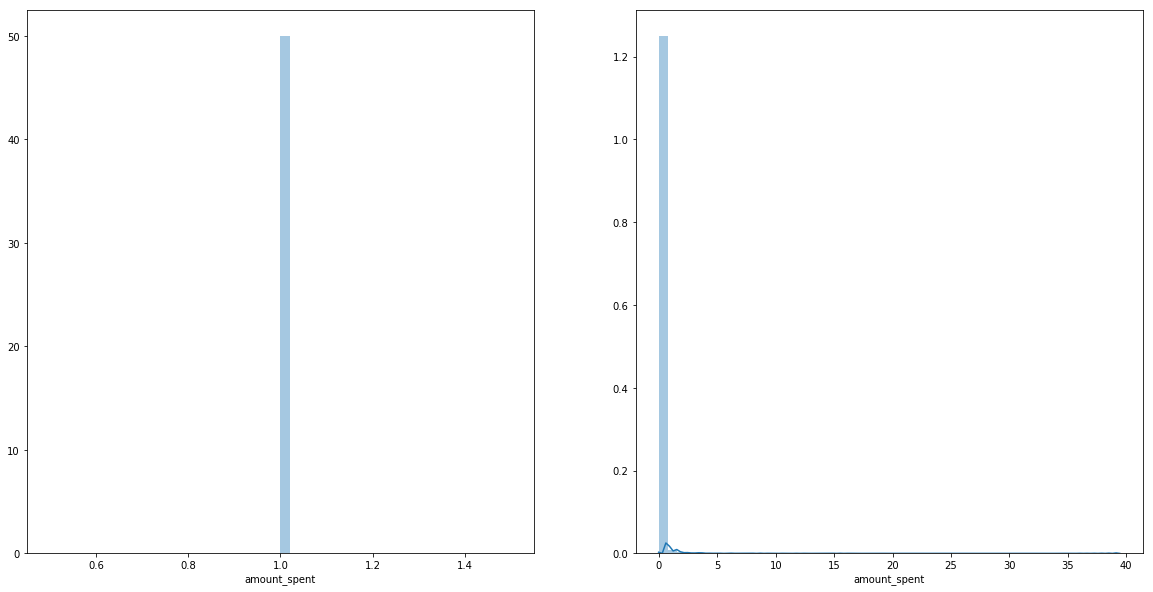

In [44]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.distplot(oof2_df2['amount_spent'])

plt.subplot(1, 2, 2)
sns.distplot(train_label['amount_spent'])

plt.show()

In [29]:
oof2_df2['survival_time'].min(), oof2_df2['survival_time'].mean(), oof2_df2['survival_time'].max(), oof2_df2['amount_spent'].min(), oof2_df2['amount_spent'].mean(), oof2_df2['amount_spent'].max()

(5, 9.178275, 15, 1.0, 1.0, 1.0)

In [0]:
pred2_df = pd.DataFrame([np.unique(test2_log['acc_id']), pred2_time.astype(int), pred2_spent]).T
pred2_df.columns = train_label.columns
pred2_df[['acc_id', 'survival_time']] = pred2_df[['acc_id', 'survival_time']].astype(int)

pred2_df.loc[pred2_df['survival_time']<1, 'survival_time'] = 1
pred2_df.loc[pred2_df['survival_time']>64, 'survival_time'] = 64

pred2_df['amount_spent'] = pred2_df['amount_spent']/10

pred2_df.loc[(pred2_df['amount_spent']<1) | (pred2_df['amount_spent'].isnull()), 'amount_spent'] = 1

pred2_df.to_csv('./HH/0830/test2_predict.csv', index=False, encoding='utf-8')